In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, 
                             confusion_matrix, roc_curve, balanced_accuracy_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint, loguniform

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

In [18]:
data_dir = "../data/processed/"

X_train = np.load(f"{data_dir}X_train.npy")
X_test = np.load(f"{data_dir}X_test.npy")
y_train = np.load(f"{data_dir}y_train.npy")
y_test = np.load(f"{data_dir}y_test.npy")

with open(f"{data_dir}feature_names.txt", 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Conversores treino: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"Conversores teste: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

X_train: (472, 27)
X_test: (119, 27)
Conversores treino: 153 (32.4%)
Conversores teste: 39 (32.8%)


## Selecao de features com RFE

In [19]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfe_selector = RFECV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1
)

rfe_selector.fit(X_train, y_train)

feature_indices_rfe = np.where(rfe_selector.support_)[0]
selected_features = [feature_names[i] for i in feature_indices_rfe]

print(f"Numero de features selecionadas: {len(selected_features)}")
print(f"Features: {selected_features}")

Numero de features selecionadas: 24
Features: ['age', 'pteducat', 'mmse', 'adas11', 'adas13', 'cdrsb', 'ravlt_immediate', 'ravlt_learning', 'ravlt_forgetting', 'ravlt_perc_forgetting', 'faq', 'moca', 'hippocampus', 'wholebrain', 'entorhinal', 'fusiform', 'midtemp', 'icv', 'fdg', 'av45', 'apoe4', 'ptgender_encoded', 'tau_encoded', 'ptau_encoded']


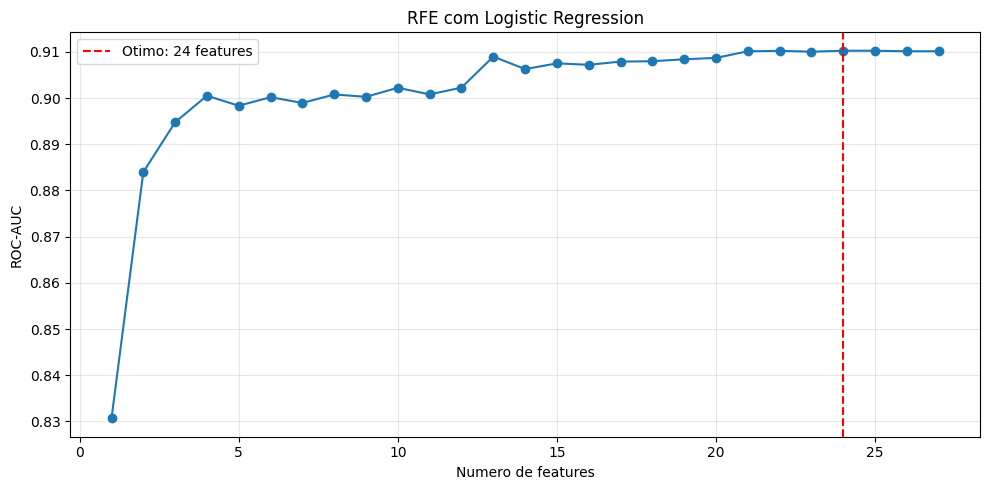

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rfe_selector.cv_results_['mean_test_score']) + 1),
         rfe_selector.cv_results_['mean_test_score'], 'o-')
plt.xlabel('Numero de features')
plt.ylabel('ROC-AUC')
plt.title('RFE com Logistic Regression')
plt.axvline(rfe_selector.n_features_, color='r', linestyle='--', 
            label=f'Otimo: {rfe_selector.n_features_} features')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Configuracao dos modelos com Bayesian Optimization

In [21]:
models_config = {
    'Elastic_Net': {
        'estimator': SGDClassifier(loss='log_loss', penalty='elasticnet', 
                                   max_iter=1000, random_state=42),
        'param_distributions': {
            'alpha': loguniform(1e-6, 1e-2),
            'l1_ratio': uniform(0.01, 0.98)
        }
    },
    
    'SVM_RBF': {
        'estimator': SVC(kernel='rbf', probability=True, random_state=42),
        'param_distributions': {
            'C': loguniform(1e-2, 1e3),
            'gamma': loguniform(1e-4, 1e1)
        }
    },
    
    'XGBoost': {
        'estimator': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'param_distributions': {
            'n_estimators': randint(100, 1001),
            'max_depth': randint(3, 11),
            'learning_rate': loguniform(0.001, 0.3),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'min_child_weight': randint(1, 11),
            'gamma': uniform(0, 0.5)
        }
    },
    
    'LightGBM': {
        'estimator': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'param_distributions': {
            'n_estimators': randint(100, 1001),
            'max_depth': randint(3, 11),
            'learning_rate': loguniform(0.001, 0.3),
            'num_leaves': randint(20, 151),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'min_child_samples': randint(5, 51)
        }
    },
    
    'Gradient_Boosting': {
        'estimator': GradientBoostingClassifier(n_estimators=500, random_state=42),
        'param_distributions': {
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth': randint(2, 9),
            'min_samples_split': randint(2, 21),
            'subsample': uniform(0.7, 0.3),
            'max_features': ['sqrt', 'log2', None]
        }
    },
    
    'MLP': {
        'estimator': MLPClassifier(max_iter=1000, random_state=42, early_stopping=True),
        'param_distributions': {
            'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 75), (200, 100)],
            'activation': ['relu', 'tanh'],
            'alpha': loguniform(1e-5, 1e-2),
            'learning_rate_init': loguniform(1e-4, 1e-2)
        }
    }
}

print(f"Modelos configurados: {len(models_config)}")

Modelos configurados: 6


## Treinamento com Bayesian Optimization

In [22]:
results = []
trained_models = {}
cv_strategy_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_sets = {
    'all': list(range(X_train.shape[1])),
    'rfe': feature_indices_rfe.tolist()
}

for model_name, config in models_config.items():
    for feature_set_name, feature_indices in feature_sets.items():
        
        print(f"\nTreinando {model_name} com {feature_set_name}")
        start_time = time.time()
        
        X_train_subset = X_train[:, feature_indices]
        X_test_subset = X_test[:, feature_indices]
        
        random_search = RandomizedSearchCV(
            estimator=config['estimator'],
            param_distributions=config['param_distributions'],
            n_iter=40,
            cv=cv_strategy_final,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        random_search.fit(X_train_subset, y_train)
        
        training_time = time.time() - start_time
        
        best_model = random_search.best_estimator_
        cv_roc_auc = random_search.best_score_
        
        y_pred_proba = best_model.predict_proba(X_test_subset)[:, 1]
        y_pred = best_model.predict(X_test_subset)
        
        test_roc_auc = roc_auc_score(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
        
        result = {
            'Model': model_name,
            'Features': feature_set_name,
            'N_Features': len(feature_indices),
            'CV_ROC_AUC': cv_roc_auc,
            'Test_ROC_AUC': test_roc_auc,
            'Test_Accuracy': test_accuracy,
            'Test_F1': test_f1,
            'Test_Balanced_Acc': test_balanced_acc,
            'Training_Time': training_time
        }
        results.append(result)
        
        model_key = f"{model_name}_{feature_set_name}"
        trained_models[model_key] = {
            'model': best_model,
            'feature_indices': feature_indices,
            'random_search': random_search,
            'best_params': random_search.best_params_
        }
        
        print(f"CV ROC-AUC: {cv_roc_auc:.4f}")
        print(f"Test ROC-AUC: {test_roc_auc:.4f}")
        print(f"Tempo: {training_time:.1f}s")


Treinando Elastic_Net com all
CV ROC-AUC: 0.9099
Test ROC-AUC: 0.8712
Tempo: 0.5s

Treinando Elastic_Net com rfe
CV ROC-AUC: 0.9122
Test ROC-AUC: 0.8728
Tempo: 0.5s

Treinando SVM_RBF com all
CV ROC-AUC: 0.9118
Test ROC-AUC: 0.8718
Tempo: 3.5s

Treinando SVM_RBF com rfe
CV ROC-AUC: 0.9128
Test ROC-AUC: 0.8772
Tempo: 3.2s

Treinando XGBoost com all
CV ROC-AUC: 0.9132
Test ROC-AUC: 0.8696
Tempo: 23.5s

Treinando XGBoost com rfe
CV ROC-AUC: 0.9135
Test ROC-AUC: 0.8699
Tempo: 22.2s

Treinando LightGBM com all
CV ROC-AUC: 0.9110
Test ROC-AUC: 0.8763
Tempo: 22.7s

Treinando LightGBM com rfe
CV ROC-AUC: 0.9134
Test ROC-AUC: 0.8769
Tempo: 20.9s

Treinando Gradient_Boosting com all
CV ROC-AUC: 0.9065
Test ROC-AUC: 0.8798
Tempo: 105.1s

Treinando Gradient_Boosting com rfe
CV ROC-AUC: 0.9071
Test ROC-AUC: 0.8712
Tempo: 99.7s

Treinando MLP com all
CV ROC-AUC: 0.9075
Test ROC-AUC: 0.8455
Tempo: 6.5s

Treinando MLP com rfe
CV ROC-AUC: 0.9021
Test ROC-AUC: 0.8712
Tempo: 7.5s


In [23]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_ROC_AUC', ascending=False).reset_index(drop=True)

print(results_df[['Model', 'Features', 'N_Features', 'CV_ROC_AUC', 
                   'Test_ROC_AUC', 'Test_Accuracy', 'Test_F1', 'Test_Balanced_Acc']].to_string(index=False))

print(f"\nMelhor: {results_df['Model'].iloc[0]} com {results_df['Features'].iloc[0]}")
print(f"ROC-AUC: {results_df['Test_ROC_AUC'].iloc[0]:.4f}")

            Model Features  N_Features  CV_ROC_AUC  Test_ROC_AUC  Test_Accuracy  Test_F1  Test_Balanced_Acc
Gradient_Boosting      all          27    0.906524      0.879808       0.831933 0.722222           0.789583
          SVM_RBF      rfe          24    0.912820      0.877244       0.815126 0.676471           0.757372
         LightGBM      rfe          24    0.913374      0.876923       0.806723 0.701299           0.777404
         LightGBM      all          27    0.910997      0.876282       0.815126 0.717949           0.790224
      Elastic_Net      rfe          24    0.912191      0.872756       0.806723 0.676056           0.757692
          SVM_RBF      all          27    0.911797      0.871795       0.823529 0.695652           0.770192
      Elastic_Net      all          27    0.909854      0.871154       0.798319 0.657143           0.744872
Gradient_Boosting      rfe          24    0.907132      0.871154       0.823529 0.720000           0.789904
              MLP      rfe  

## Calibracao de probabilidades

In [24]:
best_idx = results_df['Test_ROC_AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_features = results_df.loc[best_idx, 'Features']
best_model_key = f"{best_model_name}_{best_features}"

best_model_info = trained_models[best_model_key]
best_model = best_model_info['model']
best_feature_indices = best_model_info['feature_indices']

X_train_best = X_train[:, best_feature_indices]
X_test_best = X_test[:, best_feature_indices]

calibrated_model = CalibratedClassifierCV(
    best_model,
    cv=5,
    method='sigmoid'
)

calibrated_model.fit(X_train_best, y_train)

y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_best)[:, 1]
y_pred_proba_uncalibrated = best_model.predict_proba(X_test_best)[:, 1]

print(f"ROC-AUC sem calibracao: {roc_auc_score(y_test, y_pred_proba_uncalibrated):.4f}")
print(f"ROC-AUC com calibracao: {roc_auc_score(y_test, y_pred_proba_calibrated):.4f}")

ROC-AUC sem calibracao: 0.8798
ROC-AUC com calibracao: 0.8776


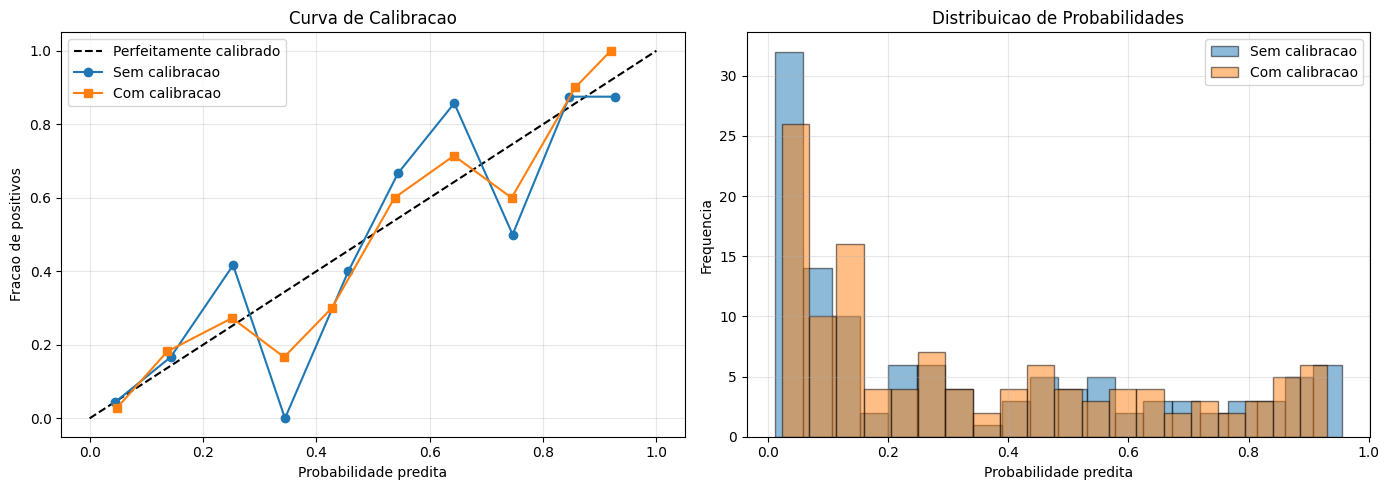

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
    y_test, y_pred_proba_uncalibrated, n_bins=10
)

fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, y_pred_proba_calibrated, n_bins=10
)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfeitamente calibrado')
axes[0].plot(mean_predicted_value_uncal, fraction_of_positives_uncal, 'o-',
             label='Sem calibracao')
axes[0].plot(mean_predicted_value_cal, fraction_of_positives_cal, 's-',
             label='Com calibracao')
axes[0].set_xlabel('Probabilidade predita')
axes[0].set_ylabel('Fracao de positivos')
axes[0].set_title('Curva de Calibracao')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(y_pred_proba_uncalibrated, bins=20, alpha=0.5, 
             label='Sem calibracao', edgecolor='black')
axes[1].hist(y_pred_proba_calibrated, bins=20, alpha=0.5, 
             label='Com calibracao', edgecolor='black')
axes[1].set_xlabel('Probabilidade predita')
axes[1].set_ylabel('Frequencia')
axes[1].set_title('Distribuicao de Probabilidades')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Ensemble com rank averaging

In [26]:
top_n = 3
top_models = results_df.nlargest(top_n, 'Test_ROC_AUC')

predictions_train = []
predictions_test = []
weights = []

for idx, row in top_models.iterrows():
    model_key = f"{row['Model']}_{row['Features']}"
    model_info = trained_models[model_key]
    model = model_info['model']
    feature_indices = model_info['feature_indices']
    
    X_train_subset = X_train[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    pred_train = cross_val_predict(
        model, X_train_subset, y_train,
        cv=cv_strategy_final,
        method='predict_proba'
    )[:, 1]
    
    pred_test = model.predict_proba(X_test_subset)[:, 1]
    
    predictions_train.append(pred_train)
    predictions_test.append(pred_test)
    weights.append(row['CV_ROC_AUC'])
    
    print(f"{model_key}: CV ROC-AUC = {row['CV_ROC_AUC']:.4f}")

predictions_train = np.column_stack(predictions_train)
predictions_test = np.column_stack(predictions_test)
weights = np.array(weights)

Gradient_Boosting_all: CV ROC-AUC = 0.9065
SVM_RBF_rfe: CV ROC-AUC = 0.9128
LightGBM_rfe: CV ROC-AUC = 0.9134


In [27]:
rank_train = pd.DataFrame(predictions_train).rank(axis=0) / len(y_train)
rank_test = pd.DataFrame(predictions_test).rank(axis=0) / len(y_test)

ensemble_pred_train = np.average(rank_train, axis=1, weights=weights)
ensemble_pred_test = np.average(rank_test, axis=1, weights=weights)

ensemble_roc_train = roc_auc_score(y_train, ensemble_pred_train)
ensemble_roc_test = roc_auc_score(y_test, ensemble_pred_test)

print(f"\nEnsemble (Rank Averaging):")
print(f"ROC-AUC Train: {ensemble_roc_train:.4f}")
print(f"ROC-AUC Test: {ensemble_roc_test:.4f}")

print(f"\nMelhor modelo individual:")
print(f"ROC-AUC Test: {results_df['Test_ROC_AUC'].iloc[0]:.4f}")

diff = ensemble_roc_test - results_df['Test_ROC_AUC'].iloc[0]
print(f"\nDiferenca: {diff:+.4f}")


Ensemble (Rank Averaging):
ROC-AUC Train: 0.9167
ROC-AUC Test: 0.8878

Melhor modelo individual:
ROC-AUC Test: 0.8798

Diferenca: +0.0080


## Threshold otimizado para balanced accuracy

In [28]:
def find_best_threshold(y_true, y_pred_proba):
    best_threshold = 0.5
    best_balanced_acc = 0
    
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_pred_proba >= threshold).astype(int)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_threshold = threshold
    
    return best_threshold, best_balanced_acc

threshold_opt, balanced_acc_opt = find_best_threshold(y_train, ensemble_pred_train)

print(f"Threshold otimo: {threshold_opt:.3f}")
print(f"Balanced Accuracy (train): {balanced_acc_opt:.4f}")

y_pred_ensemble = (ensemble_pred_test >= threshold_opt).astype(int)

cm = confusion_matrix(y_test, y_pred_ensemble)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
balanced_acc_test = (sensitivity + specificity) / 2

print(f"\nMetricas no teste com threshold {threshold_opt:.3f}:")
print(f"Balanced Accuracy: {balanced_acc_test:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_ensemble):.4f}")

Threshold otimo: 0.550
Balanced Accuracy (train): 0.8414

Metricas no teste com threshold 0.550:
Balanced Accuracy: 0.7853
Sensitivity: 0.8205
Specificity: 0.7500
PPV: 0.6154
NPV: 0.8955
F1-Score: 0.7033


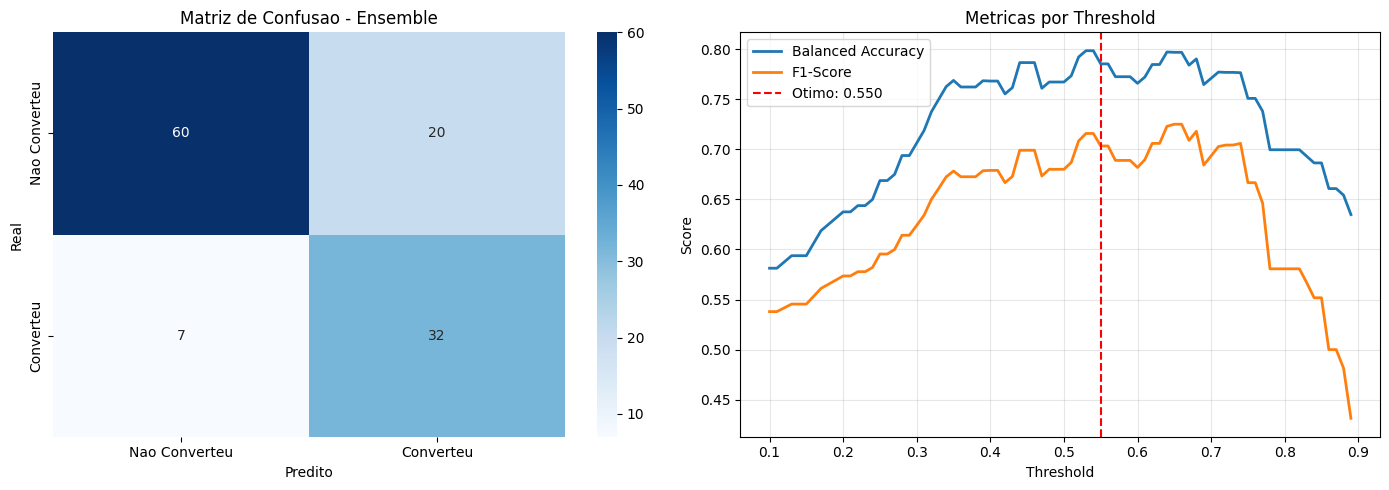

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Nao Converteu', 'Converteu'],
            yticklabels=['Nao Converteu', 'Converteu'],
            ax=axes[0])
axes[0].set_title('Matriz de Confusao - Ensemble')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')

thresholds = np.arange(0.1, 0.9, 0.01)
balanced_accs = []
f1_scores = []

for t in thresholds:
    y_pred_t = (ensemble_pred_test >= t).astype(int)
    balanced_accs.append(balanced_accuracy_score(y_test, y_pred_t))
    f1_scores.append(f1_score(y_test, y_pred_t))

axes[1].plot(thresholds, balanced_accs, label='Balanced Accuracy', linewidth=2)
axes[1].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
axes[1].axvline(threshold_opt, color='r', linestyle='--', 
                label=f'Otimo: {threshold_opt:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Metricas por Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Analise dos hiperparametros otimizados

In [30]:
print("Melhores hiperparametros por modelo:\n")

for idx, row in top_models.iterrows():
    model_key = f"{row['Model']}_{row['Features']}"
    best_params = trained_models[model_key]['best_params']
    
    print(f"{row['Model']} ({row['Features']}):")
    print(f"  ROC-AUC: {row['Test_ROC_AUC']:.4f}")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    print()

Melhores hiperparametros por modelo:

Gradient_Boosting (all):
  ROC-AUC: 0.8798
  learning_rate: 0.0125
  max_depth: 3
  max_features: log2
  min_samples_split: 8
  subsample: 0.8492

SVM_RBF (rfe):
  ROC-AUC: 0.8772
  C: 71.8376
  gamma: 0.0002

LightGBM (rfe):
  ROC-AUC: 0.8769
  colsample_bytree: 0.6550
  learning_rate: 0.0070
  max_depth: 3
  min_child_samples: 27
  n_estimators: 514
  num_leaves: 61
  subsample: 0.7032



## Comparacao com modelos anteriores

In [31]:
models_dir = "../models/"

try:
    advanced_results = pd.read_csv(f"{models_dir}advanced_models_results.csv")
    
    print("Comparacao: Bayesian Optimization vs Modelos Anteriores")
    print("\nTop 3 modelos avancados (RandomizedSearchCV):")
    advanced_top = advanced_results.nlargest(3, 'Test_ROC_AUC')
    print(advanced_top[['Model', 'Features', 'Test_ROC_AUC', 'Test_Accuracy']].to_string(index=False))
    
    print("\nTop 3 modelos com Bayesian Optimization:")
    print(results_df.head(3)[['Model', 'Features', 'Test_ROC_AUC', 'Test_Accuracy']].to_string(index=False))
    
    print(f"\nEnsemble Rank Averaging:")
    print(f"  ROC-AUC: {ensemble_roc_test:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc_test:.4f}")
    
    best_previous = advanced_results['Test_ROC_AUC'].max()
    improvement = ensemble_roc_test - best_previous
    
    print(f"\nMelhoria vs melhor anterior: {improvement:+.4f}")
    
except FileNotFoundError:
    print("Resultados anteriores nao encontrados")

Comparacao: Bayesian Optimization vs Modelos Anteriores

Top 3 modelos avancados (RandomizedSearchCV):
   Model Features  Test_ROC_AUC  Test_Accuracy
 XGBoost    top15      0.874359       0.815126
LightGBM    top10      0.874359       0.798319
 XGBoost    top10      0.874038       0.823529

Top 3 modelos com Bayesian Optimization:
            Model Features  Test_ROC_AUC  Test_Accuracy
Gradient_Boosting      all      0.879808       0.831933
          SVM_RBF      rfe      0.877244       0.815126
         LightGBM      rfe      0.876923       0.806723

Ensemble Rank Averaging:
  ROC-AUC: 0.8878
  Balanced Accuracy: 0.7853

Melhoria vs melhor anterior: +0.0135


## Salvando resultados

In [32]:
os.makedirs(models_dir, exist_ok=True)

for model_key, model_info in trained_models.items():
    filename = f"bayesopt_{model_key.lower().replace(' ', '_')}.pkl"
    filepath = os.path.join(models_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"{model_key} salvo")

results_df.to_csv(os.path.join(models_dir, 'bayesopt_results.csv'), index=False)
print(f"\nResultados salvos em: {models_dir}")

ensemble_info = {
    'predictions_test': ensemble_pred_test,
    'threshold': threshold_opt,
    'roc_auc': ensemble_roc_test,
    'balanced_accuracy': balanced_acc_test,
    'top_models': top_models['Model'].tolist(),
    'weights': weights.tolist()
}

with open(os.path.join(models_dir, 'ensemble_rank_averaging.pkl'), 'wb') as f:
    pickle.dump(ensemble_info, f)

print("Ensemble salvo")

Elastic_Net_all salvo
Elastic_Net_rfe salvo
SVM_RBF_all salvo
SVM_RBF_rfe salvo
XGBoost_all salvo
XGBoost_rfe salvo
LightGBM_all salvo
LightGBM_rfe salvo
Gradient_Boosting_all salvo
Gradient_Boosting_rfe salvo
MLP_all salvo
MLP_rfe salvo

Resultados salvos em: ../models/
Ensemble salvo


In [33]:
print("\nRESUMO FINAL")
print("="*70)
print(f"\nMelhor modelo individual: {best_model_name} ({best_features})")
print(f"  ROC-AUC: {results_df.loc[best_idx, 'Test_ROC_AUC']:.4f}")
print(f"  Balanced Accuracy: {results_df.loc[best_idx, 'Test_Balanced_Acc']:.4f}")

print(f"\nEnsemble Rank Averaging ({top_n} modelos):")
print(f"  ROC-AUC: {ensemble_roc_test:.4f}")
print(f"  Balanced Accuracy: {balanced_acc_test:.4f}")
print(f"  Threshold otimizado: {threshold_opt:.3f}")

print(f"\nTotal de modelos treinados: {len(results_df)}")
print(f"Tempo total: {results_df['Training_Time'].sum():.1f}s ({results_df['Training_Time'].sum()/60:.1f} min)")

print(f"\nTodos os resultados salvos em: {models_dir}")
print("="*70)


RESUMO FINAL

Melhor modelo individual: Gradient_Boosting (all)
  ROC-AUC: 0.8798
  Balanced Accuracy: 0.7896

Ensemble Rank Averaging (3 modelos):
  ROC-AUC: 0.8878
  Balanced Accuracy: 0.7853
  Threshold otimizado: 0.550

Total de modelos treinados: 12
Tempo total: 315.6s (5.3 min)

Todos os resultados salvos em: ../models/
